In [7]:
import pickle
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from mpl_toolkits.mplot3d import Axes3D
from keras import backend as K
# %matplotlib notebook
import glob
import pandas as pd

In [3]:
def plot_2d_landmarks(img, true, pred):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(img.reshape((80,120,3)))
    ax.autoscale(False)
    ax.plot(pred[:,0], pred[:,1], '+w')
    plt.plot(true[:,0], true[:,1], '.r')
    ax.axis('off')
    plt.show()


def plot_3d_landmarks(true, pred, gaze_vector):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    Z = true
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='.')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='.')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='.')
    
    Z = np.vstack((np.mean(Z[20:28,:], axis=0), np.mean(Z[20:28,:], axis=0) - 0.1 * gaze_vector))
    ax.plot(Z[:,0], Z[:,1], Z[:,2], c='k', marker='^', linewidth=2.0)
    
    Z = pred
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='s', ls = 'dashed')
    
    ax.axis('off')
    plt.show()


def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)
    
def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)

def landmark_accuracy(y_true, y_pred):
        return K.mean(K.abs(y_true - y_pred) < 3.)
    
def landmark_accuracy_5(y_true, y_pred):
        return K.mean(K.abs(y_true - y_pred) < 5.)

def landmark_loss(y_true, y_pred):
    return K.mean( K.square(y_true - y_pred) * K.sigmoid( K.abs(y_true - y_pred) - 1 ), axis=-1)

def model_predict(model, test_inputs, num_samples, output_dims):
    pred = model.predict(test_inputs)
    return np.reshape(pred, (num_samples, 28, output_dims))

def load_model_and_predict(filepath, test_inputs, custom_objects, num_samples, output_dims=2):
    model = load_model(filepath, custom_objects)
    pred = model_predict(model, test_inputs, num_samples, output_dims)
    return model, pred

def load_all_models():
    ld3 = []
    ld2 = []
    
    for path in glob.glob('./models/*.history'):
        with open(path, 'rb') as f:
            history = pickle.load(f)
            if len(history['val_loss']) == 70:
                model = load_model(path.replace('.history' , '.h5'), custom_objects)
                if '2D' in path:
                    ld2.append((path, model, history))
                else:
                    ld3.append((path, model, history))
        
    return ld2, ld3
        
def parse_model_desc(filepath):
    

In [5]:
# Initialization

# Load data
with open('all_data.pkl', 'rb') as f:
    images_train, images_test, ldmks_2d_train, ldmks_2d_test, ldmks_3d_train, ldmks_3d_test, head_pose_train, head_pose_test, look_vec_train, look_vec_test = pickle.load(f)

# Params
num_samples = images_test.shape[0]
    
# Feed-forward params
test_inputs = {'input_img': images_test, 'head_pose': head_pose_test}
custom_objects={'p_norm_loss': p_norm_loss, 'landmark_accuracy' : landmark_accuracy, 'landmark_loss': landmark_loss}

# Reshape for original dimensions for plotting
ldmks_2d_test = np.reshape(ldmks_2d_test, (num_samples, 28, 2))
ldmks_3d_test = np.reshape(ldmks_3d_test, (num_samples, 28, 3))
head_pose_test_raw = np.reshape(head_pose_test, (num_samples, 3,3))

In [6]:
ld2, ld3 = load_all_models()

In [4]:
model, preds = load_model_and_predict(
    'models/HeadTrue-TowerTrue-2D-mean_absolute_error-non_spatial-[1.3430979573836597, 0.91167892365796976].h5', 
    test_inputs, custom_objects, num_samples, output_dims=2)


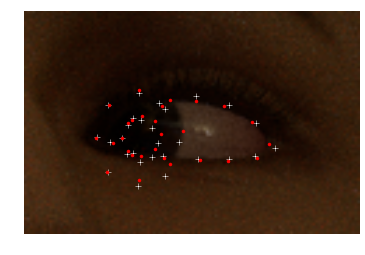

In [21]:
i = np.random.choice(num_samples)
plot_2d_landmarks(images_test[i,:,:,:], ldmks_2d_test[i,:,:], preds[i,:,:])

In [39]:


plot_3d_landmarks(ldmks_3d_test[i,:,:], pred_landmarks_3D[i,:,:], look_vec_test[i,:])

NameError: name 'pred_landmarks_3D' is not defined

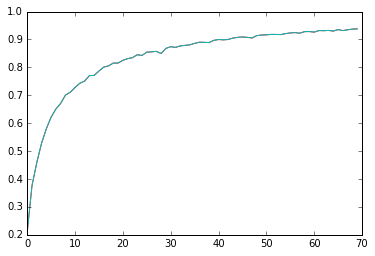

In [7]:
with open('models/HeadTrue-TowerTrue-2D-mean_absolute_error-non_spatial-[1.3430979573836597, 0.91167892365796976].history', 'rb') as f:
    hist_doubletower_mae = pickle.load(f)
    
plt.plot(hist_doubletower_mae['landmark_accuracy'])
plt.show()

In [1]:
import pickle
import matplotlib.pyplot as plt
with open('models/HeadTrue-TowerFalse-2D-landmark_loss-non_spatial-[4.910250957147249, 0.8166212013640004].history', 'rb') as f:
    history_landmark = pickle.load(f)
    
with open('models/HeadTrue-TowerFalse-2D-mean_absolute_error-non_spatial-[2.0025351818161781, 0.7804442103567697].history', 'rb') as f:
    history_mae = pickle.load(f)

with open('models/HeadTrue-TowerFalse-2D-mean_squared_error-non_spatial-[5.4612291761799554, 0.81560168234360653].history', 'rb') as f:
    history_mse = pickle.load(f)
    
with open('models/HeadFalse-TowerFalse-2D-landmark_loss-non_spatial-[6.0355695522192754, 0.7780914918131403].history', 'rb') as f:
    history_landmark_nohead = pickle.load(f)
    
with open('models/HeadFalse-TowerFalse-2D-mean_absolute_error-non_spatial-[1.7898727505155756, 0.82330292499950175].history', 'rb') as f:
    history_mae_nohead = pickle.load(f)
    
with open('models/HeadFalse-TowerFalse-2D-mean_squared_error-non_spatial-[7.0365000420303581, 0.76336346098766239].history', 'rb') as f:
    history_mse_nohead = pickle.load(f)

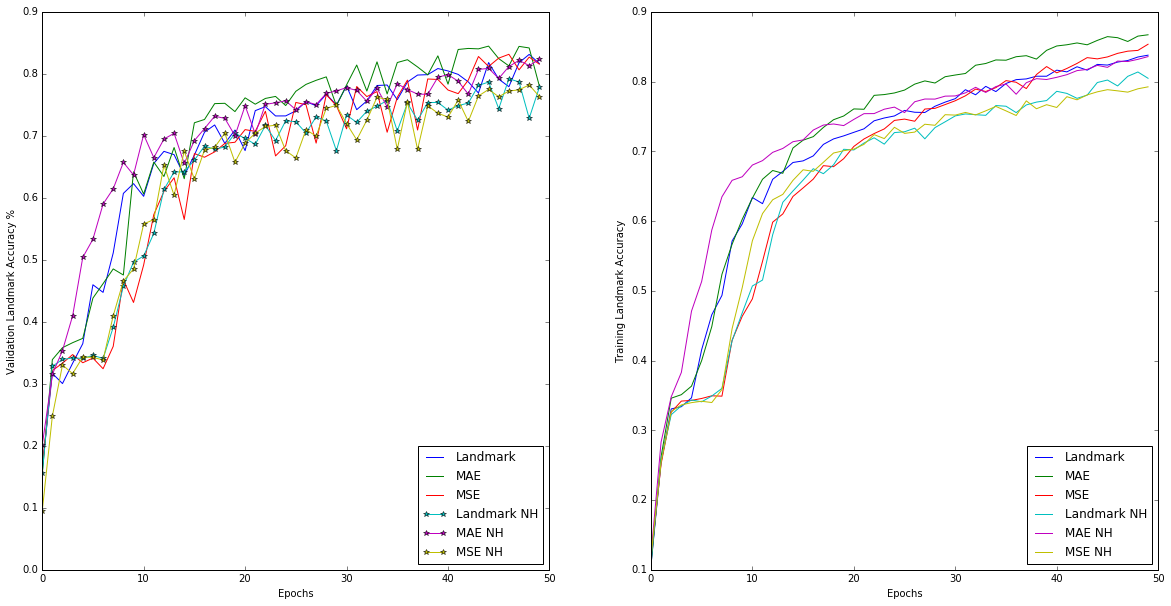

In [2]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(history_landmark['val_landmark_accuracy'], label='Landmark')
plt.plot(history_mae['val_landmark_accuracy'], label='MAE')
plt.plot(history_mse['val_landmark_accuracy'], label='MSE')

plt.plot(history_landmark_nohead['val_landmark_accuracy'], '*-', label='Landmark NH')
plt.plot(history_mae_nohead['val_landmark_accuracy'], '*-', label='MAE NH')
plt.plot(history_mse_nohead['val_landmark_accuracy'], '*-', label='MSE NH')

plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Validation Landmark Accuracy %')

plt.subplot(1,2,2)
plt.plot(history_landmark['landmark_accuracy'], label='Landmark')
plt.plot(history_mae['landmark_accuracy'], label='MAE')
plt.plot(history_mse['landmark_accuracy'], label='MSE')

plt.plot(history_landmark_nohead['landmark_accuracy'], label='Landmark NH')
plt.plot(history_mae_nohead['landmark_accuracy'], label='MAE NH')
plt.plot(history_mse_nohead['landmark_accuracy'], label='MSE NH')

plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Training Landmark Accuracy')
plt.show()